In [4]:
# Standard Library Imports
from pathlib import Path
import pandas as pd

# 3° Party Packages
!pip install pycaret --quiet
from pycaret.datasets import get_data
from pycaret.classification import *

# 1. Data preprocessing

In [21]:
# Read Data
df = pd.read_excel('/content/Merged_Categories_BI_4.xlsx')
print(f"Initial shape of data {df.shape}\n")

# Basic Data Cleaning
df = df.drop(columns=["End LogDateTime","Job_Log_ID"])
print("N° missing values for each column:")
print(df.isnull().sum())

print(f"\nThere are {df['Failure_Reason'].nunique()} distinct Failure_Reason in the data:")
print(df["Failure_Reason"].value_counts())

# Data Cleaning: Filter "Failure_Reason" categories happening less than 5 times
df = df[df['Failure_Reason'].isin(df['Failure_Reason'].value_counts()[df['Failure_Reason'].value_counts() > 5].index)]
print(f"\nKept {len(df)} rows after excluding Failure_Reason categories happening less than 5 times")

Initial shape of data (561, 16)

N° missing values for each column:
BusinessProcessName      0
machineName              0
windowsIdentity          0
TotalExecutionTime       0
Start LogDateTime        0
Error logs count         0
AppID_Assets             0
AppID-RobotRole          0
O365Role                 0
SAPRoles                 0
MaintenanceDuringJob     0
Error_Category           0
Secondary_Cause         58
Failure_Reason           0
dtype: int64

There are 18 distinct Failure_Reason in the data:
Maximum retry number                                                                                                                    158
No failure reason                                                                                                                       145
Wrong data input or not dynamic SAP/Web Selector                                                                                         46
VDI network access or Outlook login needed                            

In [6]:
# Add new columns for Month, Day of week, Hour of day
df['Month'] = df['Start LogDateTime'].dt.month
df['Day of week'] = df['Start LogDateTime'].dt.dayofweek
df['Hour of day'] = df['Start LogDateTime'].dt.hour
df.head()

,BusinessProcessName,machineName,windowsIdentity,TotalExecutionTime,Start LogDateTime,Error logs count,AppID_Assets,AppID-RobotRole,O365Role,SAPRoles,MaintenanceDuringJob,Error_Category,Secondary_Cause,Failure_Reason,Month,Day of week,Hour of day
0,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Orchestrator error,User credentials,VDI network access or Outlook login needed,5,2,14
1,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Null reference error,Older Dependency,Uninitialized variable /argument within or bet...,5,2,14
2,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Orchestrator error,Older Dependency,No email address added or invalid address,5,2,14
3,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:01:27,2023-06-02 10:26:16.868,9,1,1,1,1,0,UiPath Malfunctioning code,Older Dependency,URL/Path access denied,6,4,10
4,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:01:27,2023-06-02 10:26:16.868,9,1,1,1,1,0,Maximum retry error,Older Dependency,Maximum retry number,6,4,10


# 2. Initialize Pycaret Setup and perform Data Preprocessing
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function. It takes two mandatory parameters: data and target. All the other parameters are optional.

In [7]:
clf = setup(data=df, target = 'Failure_Reason',
            # ordinal_features=None, numeric_features=None, categorical_features=None,  date_features=None,
            train_size=0.7, fold=3, fold_shuffle=True,
            # fix_imbalance=False, fix_imbalance_method="SMOTE",
            feature_selection=False, feature_selection_method="classic", n_features_to_select=0.9,
            session_id=1,
            )

,Description,Value
0,Session id,1
1,Target,Failure_Reason
2,Target type,Multiclass
3,Target mapping,"Additional permissions for an asset or a package are needed: 0, Cancellation Request: 1, Excel is unavailable or already running: 2, Item with same name exists: 3, Maximum retry number: 4, No IAM Role access rights: 5, No email address added or invalid address: 6, No failure reason: 7, Potential Data errors (MaxLength limit, wrong column name or non existing column) or potential logic errors (arguments, index, path): 8, SAP starten activity: 9, String manipulation (substring range,DateTime format, null or dynamic string) : 10, URL/Path access denied: 11, UiPath extension is missing or disabled: 12, Uninitialized variable /argument within or between workflows: 13, VDI network access or Outlook login needed: 14, Wrong data input or not dynamic SAP/Web Selector: 15"
4,Original data shape,"(556, 17)"
5,Transformed data shape,"(556, 59)"
6,Transformed train set shape,"(389, 59)"
7,Transformed test set shape,"(167, 59)"
8,Numeric features,9
9,Date features,1


# 3. Fit multiple models, compare their results, save the top 3 models
*compare_models* trains and evaluates performance of all estimators available in the model library using cross validation. The output of this function is a score grid with average cross validated scores. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [8]:
top_3_models = compare_models(n_select = 3,
                              sort="F1",
                              turbo=False,
                              cross_validation=True # When set to False, metrics are evaluated on holdout set
                              )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9537,0.9986,0.9537,0.9568,0.9497,0.9443,0.9449,0.3833
rf,Random Forest Classifier,0.9434,0.9982,0.9434,0.9479,0.9398,0.9319,0.9324,0.4300
gbc,Gradient Boosting Classifier,0.9435,0.9962,0.9435,0.9478,0.9382,0.9320,0.9328,2.3967
xgboost,Extreme Gradient Boosting,0.9332,0.9973,0.9332,0.9286,0.9245,0.9197,0.9205,0.4000
dt,Decision Tree Classifier,0.9126,0.9550,0.9126,0.9156,0.9098,0.8950,0.8956,0.4433
ridge,Ridge Classifier,0.9177,0.0000,0.9177,0.9011,0.9019,0.9010,0.9025,0.1967
nb,Naive Bayes,0.8791,0.9699,0.8791,0.9123,0.8842,0.8553,0.8573,0.4733
lightgbm,Light Gradient Boosting Machine,0.8046,0.9801,0.8046,0.8012,0.7966,0.7650,0.7660,1.8733
mlp,MLP Classifier,0.7687,0.9519,0.7687,0.7384,0.7337,0.7159,0.7226,0.4767
ada,Ada Boost Classifier,0.7528,0.9536,0.7528,0.7024,0.7106,0.6995,0.7314,0.4600


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

# 4. Create and Tune one single model
## 4.1 Create a model
This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function. All the available models can be accessed using the models function.

In [9]:
m1 = create_model(top_3_models[0], round = 2, cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.94,1.00,0.94,0.93,0.93,0.93,0.93
1,0.98,1.00,0.98,0.98,0.98,0.97,0.97
2,0.95,1.00,0.95,0.96,0.94,0.93,0.94
Mean,0.95,1.00,0.95,0.96,0.95,0.94,0.94
Std,0.02,0.00,0.02,0.02,0.02,0.02,0.02


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## 4.2 Model tuning
This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [10]:
tuned_m1 = tune_model(m1, round=2, n_iter=20, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.95,1.00,0.95,0.95,0.95,0.94,0.94
1,0.94,1.00,0.94,0.93,0.93,0.93,0.93
2,0.94,1.00,0.94,0.94,0.93,0.92,0.93
Mean,0.94,1.00,0.94,0.94,0.94,0.93,0.93
Std,0.01,0.00,0.01,0.01,0.01,0.01,0.01


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# 5. Evaluate a Model by checking multiple plots
Before model finalization, we can analyze the performance across different aspects such as AUC, confusion_matrix, decision boundary etc.

*evaluate_model* and *plot_model* functions take a trained model object in input and returns a plot based on the test / hold-out set.

There are 15 different plots available, please see the plot_model() docstring for the list of available plots.

## 5.1 Evaluate model with interactive charts
Displays a user interface for analyzing performance of a trained model on holdout set.

In [22]:
evaluate_model(tuned_m1, plot_kwargs = {'size':(1200, 800)})

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## 5.1 AUC Plot

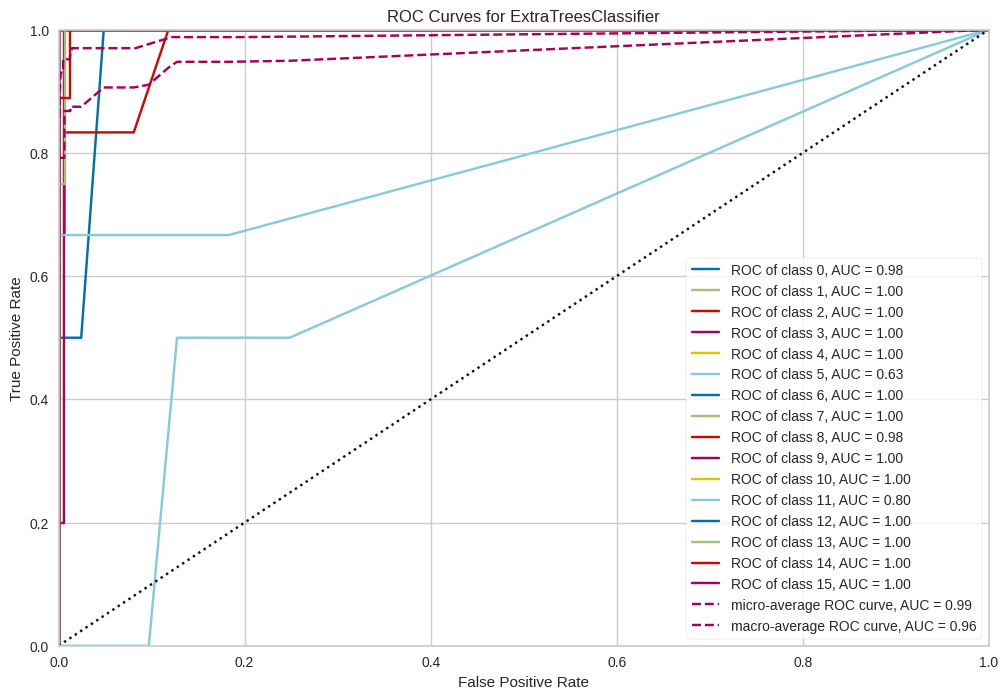

In [12]:
plot_model(tuned_m1, plot = 'auc', plot_kwargs = {'size':(1200, 800)})

## 5.2 Precision-Recall Curve

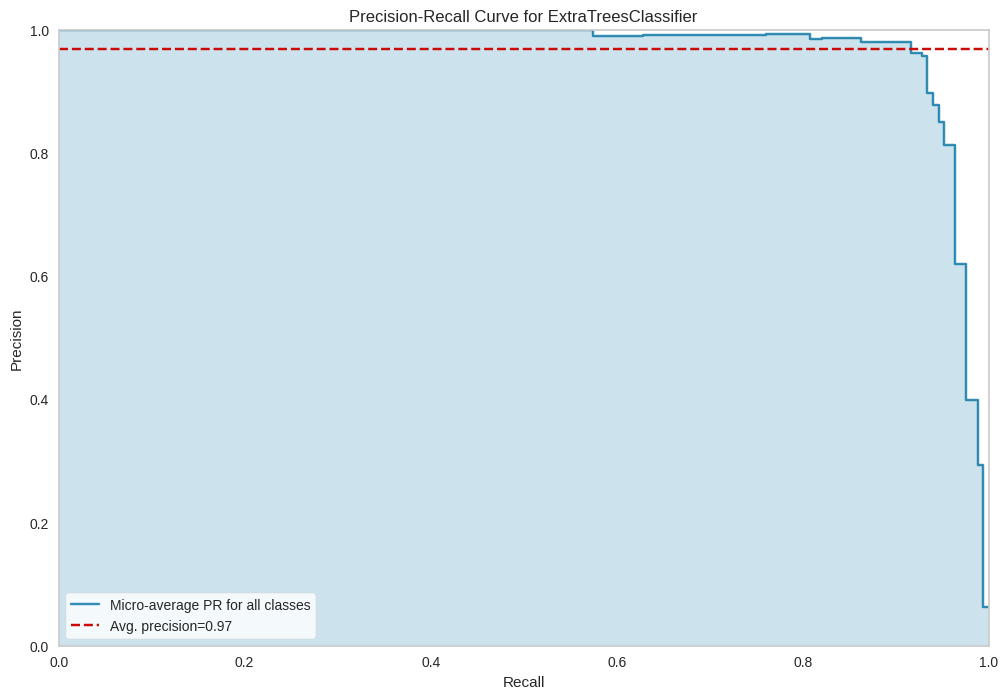

In [13]:
plot_model(tuned_m1, plot = 'pr', plot_kwargs = {'size':(1200, 800)})

## 5.3  Feature Importance Plot

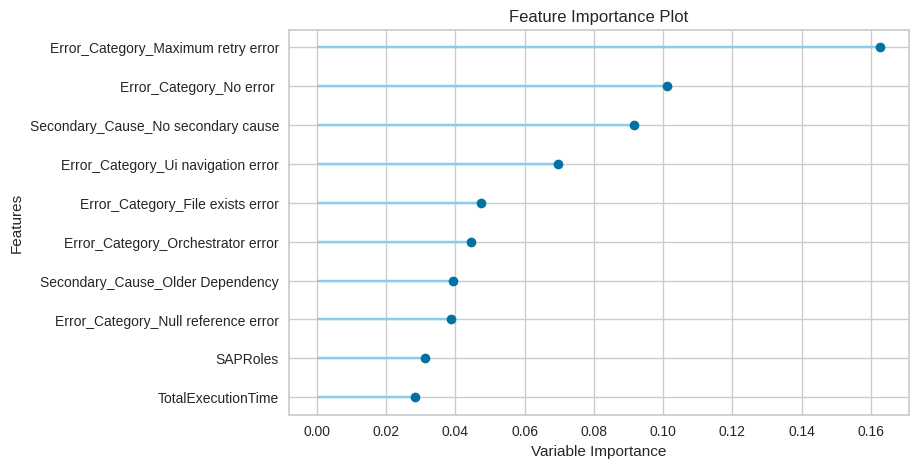

In [14]:
plot_model(tuned_m1, plot='feature', plot_kwargs = {'size':(1200, 800)})

## 5.4 Confusion Matrix

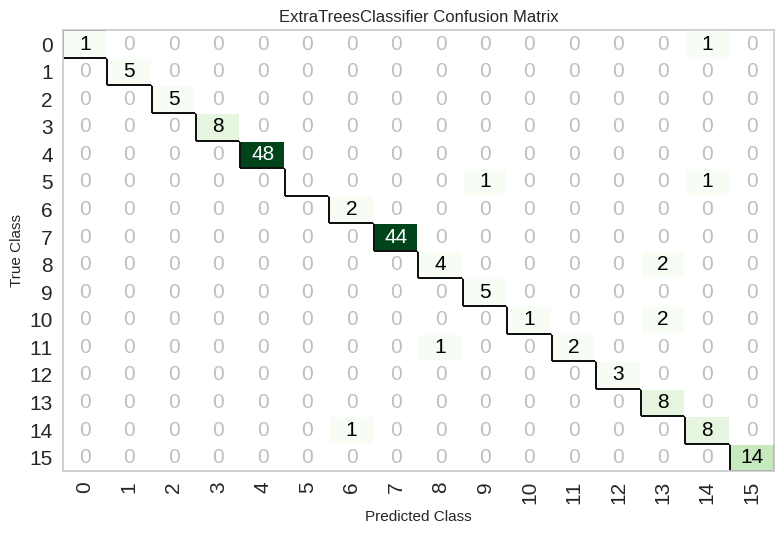

In [15]:
plot_model(tuned_m1, plot='confusion_matrix')

# 6. Finalize Model for Deployment
Model finalization is the last step in the experiment. A normal machine learning workflow in PyCaret starts with setup(), followed by comparing all models using compare_models() and shortlisting a few candidate models (based on the metric of interest) to perform several modeling techniques such as hyperparameter tuning, ensembling, stacking etc. This workflow will eventually lead you to the best model for use in making predictions on new and unseen data. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [17]:
# Make predictions using the tuned model
predictions = predict_model(tuned_m1, round=2) # data=unseen_data
print(predictions.shape)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.95,0.99,0.95,0.95,0.94,0.93,0.94


(167, 19)


,BusinessProcessName,machineName,windowsIdentity,TotalExecutionTime,Start LogDateTime,Error logs count,AppID_Assets,AppID-RobotRole,O365Role,SAPRoles,MaintenanceDuringJob,Error_Category,Secondary_Cause,Month,Day of week,Hour of day,Failure_Reason,prediction_label,prediction_score
211,Automatisierte CSV Import Part2,KADPIF0000188,DM\X0A05258,0:01:07,2023-06-06 15:28:41.663,11,1,1,1,0,0,Maximum retry error,Older Dependency,6,1,15,Maximum retry number,Maximum retry number,0.89
492,V7592.SharepointExcelActivities,KADPIF0000189,DM\X0A05334,0:04:32,2023-08-28 12:15:20.221,0,1,1,1,1,0,No error,No secondary cause,8,0,12,No failure reason,No failure reason,0.99
83,Automatisierte CSV Import Part1,KADPIF0000188,DM\X0A05258,0:00:34,2023-06-07 13:00:50.281,11,1,1,1,0,0,Maximum retry error,Older Dependency,6,2,13,Maximum retry number,Maximum retry number,1.00
491,V7592.Sharepointactivities,KADPIF0000189,DM\X0A05334,0:00:57,2023-08-28 10:26:09.795,0,1,1,1,1,0,No error,No secondary cause,8,0,10,No failure reason,No failure reason,1.00
364,V7592.SharepointExcelActivities,KADPIF0000188,DM\X0A05334,0:01:44,2023-08-15 19:30:50.441,12,1,1,1,1,0,UiPath Malfunctioning code,VDI Updates,8,1,19,Uninitialized variable /argument within or bet...,Uninitialized variable /argument within or bet...,0.66


In [16]:
final_m1 = finalize_model(tuned_m1)

# 7. Save / Load / Apply Model
## 7.1 Save/Load the transformation pipeline and trained model object into the current working directory as a pickle file.

In [18]:
save_model(model=tuned_m1, model_name='MG_model_v1');

Transformation Pipeline and Model Successfully Saved


In [19]:
saved_model = load_model('MG_model_v1')
# saved_model

Transformation Pipeline and Model Successfully Loaded


## 7.2 Apply loaded model to new unseen data (having the same structure of original data)

In [20]:
df_new = df.copy()  # You need to have in df_new a new version of the dataset with new data that was not used in the training phase
new_prediction = predict_model(saved_model, data=df_new)  # round=0
new_prediction.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9838,0.9979,0.9838,0.9850,0.9835,0.9805,0.9806


,BusinessProcessName,machineName,windowsIdentity,TotalExecutionTime,Start LogDateTime,Error logs count,AppID_Assets,AppID-RobotRole,O365Role,SAPRoles,MaintenanceDuringJob,Error_Category,Secondary_Cause,Month,Day of week,Hour of day,Failure_Reason,prediction_label,prediction_score
0,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Orchestrator error,User credentials,5,2,14,VDI network access or Outlook login needed,No email address added or invalid address,0.64
1,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Null reference error,Older Dependency,5,2,14,Uninitialized variable /argument within or bet...,Uninitialized variable /argument within or bet...,1.00
2,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:00:38,2023-05-31 14:14:45.894,5,1,0,1,1,0,Orchestrator error,Older Dependency,5,2,14,No email address added or invalid address,No email address added or invalid address,1.00
3,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:01:27,2023-06-02 10:26:16.868,9,1,1,1,1,0,UiPath Malfunctioning code,Older Dependency,6,4,10,URL/Path access denied,URL/Path access denied,0.68
4,Auslistung mit PV,KADPIF0000189,DM\X0A05099,0:01:27,2023-06-02 10:26:16.868,9,1,1,1,1,0,Maximum retry error,Older Dependency,6,4,10,Maximum retry number,Maximum retry number,0.98
